### Codigo para la propagación de onda elástica 2D PSV en un medio homogeneo poroelástico mediante el esquema velocidad - esfuerzo y rejilla escalonada (usado en tesis)
En este Notebook se presenta un codigo para la propagación de onda elástica 2D PSV en un medio homogeneo mediante el esquema velocidad - esfuerzo y rejilla escalonada propuesto por Virieux (1986), como resultado se muestra en la figura 1 cuatro cuadros donde se muestra el avance de la onda P mediante la divergencia, la onda S mediante el rotor y las velocidades $v_x$ y $v_z$

#### Termino o función fuente

En este codigo se uso como función fuente se uso una ondicula  cuya ecuación es:

$$
s= exp\left(-f_0^2*((t-t_0)*dt)^2\right)
$$

donde $f_0$ es la frecuencia dominante y $t_0$ es el retraso en tiempo

In [195]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook
import numpy as np
import numpy.matlib as npmat
import matplotlib.pyplot as plt

In [196]:
def d(comp,inpu,dire):
    if(comp=='x'): idim = 0
    elif(comp=='z'): idim = 1
    
    if(dire == '+'):
        return (9/8*(np.roll(inpu, -1, axis = idim)-inpu)
                -1/24*(np.roll(inpu, -2, axis = idim)-np.roll(inpu, 1, axis = idim)))/dx
    elif(dire == '-'):
        return (9/8*(inpu - np.roll(inpu, 1, axis = idim))
                -1/24*(np.roll(inpu, -1, axis = idim)-np.roll(inpu, 2, axis = idim)))/dx

In [197]:
# Input Parameter
# ----------------------------------------------

# Discretization
c1=20           # Number of grid points per dominant wavelength
c2=0.5          # CFL-Number for 2D CFL< 0.606
nx=400          # number of grid points in x-direction
nz=400          # number of grid points in z-direction
T=0.40
idisp = 10 # display frequency

# The grid number of pml
pml = 50                              
m = nx + 2*pml
n = nz + 2*pml
 
# Source Signal
f0= 50      # Center frequency Ricker-wavelet
q0= 1      # Maximum amplitude Ricker-Wavelet
t0= 1.5/f0
xscr = int(m/2)-1;  zscr = int(n/2)-1 # Source position (in grid points)

In [198]:
# Velocity and density
Vpp=4100*np.ones((nx,nz))   # P-wave velocity in m/s
Vss=2350*np.ones((nx,nz))   # S-wave velocity in m/s
den= 2390*np.ones((nx,nz))      # Density in Kg/m^3
rhof=1230          # Fluid Density in Kg/m^3
rhom=2650          # Mineral Density in Kg/m^3
Kmin=38e+09       # Mineral Compressibility in Pa
Ksat =22e+09      # Dry Compressibility in Pa
KF=3.8e+09        # Fluid Compressibility in Pa 
Tur= 1.0          # Tortuosity
etta =0.32e-08      # Viscosidad
kappa =1e-15       #Permeabilidad

In [199]:
# PML extra edge

Vp=np.zeros((m,n))                        # medium velocity of P wave,m/s,zero fill
Vp[pml:pml+nx,pml:pml+nz] = Vpp
Vp[pml:pml+nx,0:pml] = np.transpose(npmat.repmat(Vpp[:,0],pml,1))
Vp[pml:pml+nx,nz+pml:2*pml+nz] = np.transpose(npmat.repmat(Vpp[:,nz-1],pml,1))
Vp[0:pml,:] = npmat.repmat(Vp[pml,:],pml, 1)
Vp[pml+nx:2*pml+nx,:] = npmat.repmat(Vp[pml+nx-1,:],pml, 1)
del Vpp

Vs=np.zeros((m,n))                        # medium velocity of S wave,m/s,zero fill
Vs[pml:pml+nx,pml:pml+nz] = Vss
Vs[pml:pml+nx,0:pml] = np.transpose(npmat.repmat(Vss[:,0],pml,1))
Vs[pml:pml+nx,nz+pml:nz+2*pml] = np.transpose(npmat.repmat(Vss[:,nz-1],pml,1))
Vs[0:pml,:] = npmat.repmat(Vs[pml,:],pml, 1)
Vs[pml+nx:2*pml+nx,:] = npmat.repmat(Vs[pml+nx-1,:],pml, 1)
del Vss;

rho=np.zeros((m,n))                        # medium density,kg/m**3,zero fill
rho[pml:pml+nx,pml:pml+nz] = den;
rho[pml:pml+nx,0:pml] = np.transpose(npmat.repmat(den[:,0],pml,1))
rho[pml:pml+nx,nz+pml:nz+2*pml] = np.transpose(npmat.repmat(den[:,nz-1],pml,1))
rho[0:pml,:] = npmat.repmat(rho[pml,:],pml, 1)
rho[pml+nx:2*pml+nx,:] =npmat.repmat(rho[pml+nx-1,:],pml,1)
del den

# Calculate Lame  Parameters
lam=rho*(Vp**2 - 2*Vs**2)
mu=rho*Vs**2
phi= (rhom-rho.max())/(rhom-rhof)
KDry= (Ksat*((phi*Kmin/KF)+1-phi)-Kmin)/((phi*Kmin/KF)+(Ksat/Kmin)-1-phi)
alpha=1-(KDry/Kmin)
MM=((phi/KF)+((alpha-phi)/Kmin))**(-1)
mm=(Tur*rhof)/phi
b=(etta)/kappa
#b=0
A=(mm/((mm*rho.max())-(rhof**2)))
B=-(rhof)/((mm*rho.max())-(rhof**2))
C=-(rho.max()/((mm*rho.max())-(rhof**2)))
del Vs
print(phi,KDry,alpha,MM,mm,A,B,C)

0.18309859154929578 16508761329.305141 0.5655589123867069 17167798962.67076 6717.692307692308 0.0004619388418998048 -8.458035133376707e-05 -0.00016434718673797018


In [200]:
## Preparation 

# Init wavefields
vx=np.zeros((m,n))
vz=np.zeros((m,n))
wx=np.zeros((m,n))
wz=np.zeros((m,n))
P=np.zeros((m,n))
sxx=np.zeros((m,n))
szz=np.zeros((m,n))
sxz=np.zeros((m,n))
vx1=np.zeros((m,n))
vx2=np.zeros((m,n))
vz1=np.zeros((m,n))
vz2=np.zeros((m,n))
wx1=np.zeros((m,n))
wx2=np.zeros((m,n))
wz1=np.zeros((m,n))
wz2=np.zeros((m,n))
P1=np.zeros((m,n))
P2=np.zeros((m,n))
sxx1=np.zeros((m,n))
sxx2=np.zeros((m,n))
szz1=np.zeros((m,n))
szz2=np.zeros((m,n))
sxz1=np.zeros((m,n))
sxz2=np.zeros((m,n))

pi1=mm*rho.max()-rhof**2
pi2=mm*(lam.max()+2*mu.max())+rho.max()*MM+2*alpha*MM*rhof
pi3=MM*(lam.max()+2*mu.max()-(alpha)**2*MM)

cmin=Vp.min()  # Lowest P-wave velocity
cmax=Vp.max()  # Highest P-wave velocity
fmax=2*f0              # Maximum frequency
dx=cmin/(fmax*c1)      # Spatial discretization (in m)
dz=dx 
dt=dx/(cmax)*c2        # Temporal discretization (in s)
#dt=(dx/(9/8+1/24))*np.sqrt((pi2-np.sqrt(pi2**2-4*pi3*pi1))/(2*pi3))
lambda_min=cmin/fmax   # Smallest wavelength
#del Vp

# Create space and time vector
#x1=np.arange(0,dx*nx-dx,dx) # Space vector
#z=np.arange(0,(dz*nz-dz),dz) # Space vector
t=np.arange(0,(T-dt),dt)    # Time vector
nt=len(t)       # Number of time steps
print(dt)
print(dx)

seismovx=np.zeros(nt)
seismovz=np.zeros(nt)

0.00025
2.05


In [201]:
# Plotting velocity and density model
plt.ion()
fig1 = plt.figure()
#plt.title('P-wave Velocity Model (m/s)')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
im = plt.imshow(lam.transpose(),vmin=lam.min(), vmax=lam.max(), animated=True,
                interpolation="nearest", cmap=plt.cm.RdBu,extent=[0,(nx)*1.5,(nz)*1.5,0],aspect = 'equal')
fig1.colorbar(im)

fig2 = plt.figure()
plt.title('S-wave Velocity Model (m/s)')
plt.xlabel('x-grid')
plt.ylabel('z-grid')
im = plt.imshow(mu.transpose(),vmin=mu.min(), vmax=mu.max(), animated=True,
                interpolation="nearest", cmap=plt.cm.RdBu)
fig2.colorbar(im)

fig3 = plt.figure()
plt.title('Density Model (Kg/$m^3$)')
plt.xlabel('x-grid')
plt.ylabel('z-grid')
im = plt.imshow(rho.transpose(),vmin=rho.min(), vmax=rho.max(), animated=True,
                interpolation="nearest", cmap=plt.cm.RdBu)
fig3.colorbar(im)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [202]:
# Source signal - Ricker-wavelet

# Initialise source
tau=np.pi*f0*(t-t0);
s=q0*(1-2*tau**2)*np.exp(-tau**2);

# Plotting source signal
plt.ion()
fig4 = plt.figure(figsize=(9,4.5))
plt.plot(t-t0,s)
plt.title('Source signal Ricker-Wavelet')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show() 

<IPython.core.display.Javascript object>

In [203]:
# Attenuation(pml)
R=0.5e-0;          # theoretical reflection coefficient
ddx=np.zeros((m,n)) 
ddz=np.zeros((m,n))
plx=pml*dx
plz=pml*dz
for i in range(0,m):
     for k in range(0,n):
         # zone1
         if i>=0 and i<=pml-1 and k>=0 and k<=pml-1:
             x=pml-k;z=pml-i
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
         elif i>=0 and i<=pml-1 and k>m-pml-1 and k<=m:
             x=k-(m-pml);z=pml-i
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
         elif i>n-pml-1 and i<=n and k>=0 and k<=pml-1:
             x=pml-k;z=i-(n-pml);
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
         elif i>n-pml-1 and i<=n and k>m-pml-1 and k<=m:
             x=k-(m-pml);z=i-(n-pml);
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
  
         # zone2
         elif i<=pml-1 and k>pml-1 and k<m-pml:
             x=0;z=pml-i;
             ddx[i,k]=0
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
         elif  i>n-pml-1 and i<=n and k>pml-1 and k<=m-pml-1:
             x=0;z=i-(n-pml);
             ddx[i,k]=0
             ddz[i,k]=-np.log(R)*3*cmax*z**2/(2*plz**2)
         # zone3
         elif i>pml-1 and i<=n-pml-1 and k<=pml-1:
             x=pml-k;z=0;
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=0
         elif i>pml-1 and i<=n-pml-1 and k>m-pml-1 and k<=m:
             x=k-(m-pml);z=0;
             ddx[i,k]=-np.log(R)*3*cmax*x**2/(2*plx**2)
             ddz[i,k]=0

ddx=np.transpose(ddx)
ddz=np.transpose(ddz) 

<IPython.core.display.Javascript object>


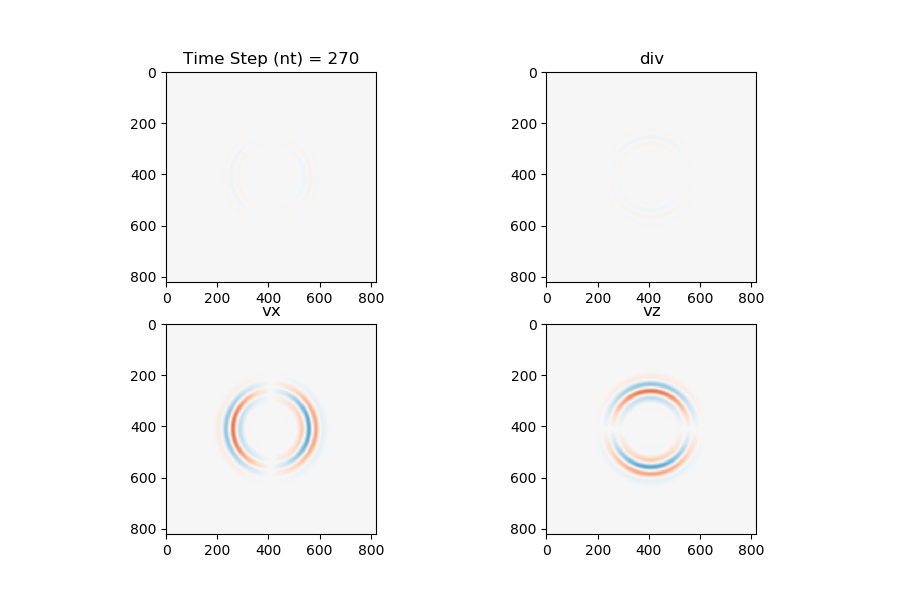

In [204]:
# Plot preparation
# Initialize animated plot
plt.ion()
fig5 = plt.figure(figsize=(9,6))
f1 = fig5.add_subplot(2, 2, 1)
f2 = fig5.add_subplot(2, 2, 2)
f3 = fig5.add_subplot(2, 2, 3)
f4 = fig5.add_subplot(2, 2, 4)
f1.set_title('curl')
f2.set_title('div')
f3.set_title('vx')
f4.set_title('vz')

curlp = f1.imshow(wx[pml:m-pml,pml:m-pml].transpose(), interpolation='nearest', animated=True,
                   vmin=-2.5e-10, vmax=2.5e-10, cmap=plt.cm.RdBu,extent=[0,(m-2*pml)*dx,(n-2*pml)*dz,0],aspect = 'equal')
divp = f2.imshow(wz[pml:m-pml,pml:m-pml].transpose(), interpolation='nearest', animated=True,
                   vmin=-2.5e-10, vmax=2.5e-10, cmap=plt.cm.RdBu,extent=[0,(m-2*pml)*dx,(n-2*pml)*dz,0],aspect = 'equal')
vxp = f3.imshow(vx[pml:m-pml,pml:m-pml].transpose(), interpolation='nearest', animated=True,
                   vmin=-2.5e-10, vmax=2.5e-10, cmap=plt.cm.RdBu,extent=[0,(m-2*pml)*dx,(n-2*pml)*dz,0],aspect = 'equal')
vzp = f4.imshow(vz[pml:m-pml,pml:m-pml].transpose(), interpolation='nearest', animated=True,
                   vmin=-2.5e-10, vmax=2.5e-10, cmap=plt.cm.RdBu,extent=[0,(m-2*pml)*dx,(n-2*pml)*dz,0],aspect = 'equal')
plt.show()

In [ ]:
for tt in range(1,nt):

    # Inject source wavelet (explosion)
    
    #sxx[xscr,zscr]=sxx[xscr,zscr]+s[tt]   
    #szz[xscr,zscr]=szz[xscr,zscr]+s[tt]
       
    sxx[xscr,zscr]=sxx[xscr,zscr]+(1-phi)*s[tt]
    szz[xscr,zscr]=szz[xscr,zscr]+(1-phi)*s[tt]
    
    P[xscr,zscr] =P[xscr,zscr] + (1-phi)*s[tt]*(phi/(1-phi))
            
    # Update velocity
    vx1= ((1-0.5*dt*ddx)*vx1 + A*d('x',sxx,'-')*dt - B*(d('x',P,'-')+b*wx1)*dt)/(1+0.5*dt*ddx)
    vx2= ((1-0.5*dt*ddz)*vx2 + A*d('z',sxz,'+')*dt - B*b*wx2*dt)/(1+0.5*dt*ddz)
    vx = vx1+vx2
    
    vz1=((1-0.5*dt*ddx)*vz1+A*d('x',sxz,'+')*dt-B*b*wz1*dt)/(1+0.5*dt*ddx)
    vz2=((1-0.5*dt*ddz)*vz2+A*d('z',szz,'-')*dt-B*(d('z',P,'-')+b*wz2)*dt)/(1+0.5*dt*ddz)
    vz = vz1+vz2 
    
    wx1= ((1-0.5*dt*ddx)*wx1 + B*d('x',sxx,'-')*dt + C*(d('x',P,'-')+b*wx1)*dt)/(1+0.5*dt*ddx)
    wx2= ((1-0.5*dt*ddz)*wx2 + B*d('z',sxz,'+')*dt + C*b*wx2*dt)/(1+0.5*dt*ddz)
    wx = wx1+wx2
    
    wz1=((1-0.5*dt*ddx)*wz1+B*d('x',sxz,'+')*dt+C*b*wz1*dt)/(1+0.5*dt*ddx)
    wz2=((1-0.5*dt*ddz)*wz2+B*d('z',szz,'-')*dt+C*(d('z',P,'-')+b*wz2)*dt)/(1+0.5*dt*ddz)
    wz = wz1+wz2          
                       
    # Update pressure
    P1=((1-0.5*dt*ddx)*P1-alpha*MM*d('x',vx,'+')*dt-MM*d('x',wx,'+')*dt)/(1+0.5*dt*ddx)
    P2=((1-0.5*dt*ddz)*P2-alpha*MM*d('z',vz,'+')*dt-MM*d('z',wz,'+')*dt)/(1+0.5*dt*ddz)
    P = P1 + P2 
    
    sxx1=((1-0.5*dt*ddx)*sxx1+(lam+2*mu)*d('x',vx,'+')*dt+alpha*MM*d('x',wx,'+')*dt)/(1+0.5*dt*ddx)
    sxx2=((1-0.5*dt*ddz)*sxx2+lam*d('z',vz,'+')*dt+alpha*MM*d('z',wz,'+')*dt)/(1+0.5*dt*ddz)
    sxx = sxx1 + sxx2    

    szz1=((1-0.5*dt*ddx)*szz1+lam*d('x',vx,'+')*dt+alpha*MM*d('x',wx,'+')*dt)/(1+0.5*dt*ddx)
    szz2=((1-0.5*dt*ddz)*szz2+(lam+2*mu)*d('z',vz,'+')*dt+alpha*MM*d('z',wz,'+')*dt)/(1+0.5*dt*ddz) 
    szz = szz1+szz2 

    sxz1=((1-0.5*dt*ddx)*sxz1+mu*dt*d('x',vz,'-'))/(1+0.5*dt*ddx)
    sxz2=((1-0.5*dt*ddz)*sxz2+mu*dt*d('z',vx,'-'))/(1+0.5*dt*ddz)
    sxz = sxz1+sxz2
    
    seismovx[tt]=vx[100,100]
    seismovz[tt]=vz[100,100]
#    # Update velocity
#    vx1=((1-0.5*dt*ddx)*vx1+(dt/rho)*d('x',sxx,'-'))/(1+0.5*dt*ddx)  
#    vx2=((1-0.5*dt*ddz)*vx2+(dt/rho)*d('z',sxz,'-'))/(1+0.5*dt*ddz)
#    vx = vx1+vx2
    
#    vz1=((1-0.5*dt*ddx)*vz1+(dt/rho)*d('x',sxz,'+'))/(1+0.5*dt*ddx)
#    vz2=((1-0.5*dt*ddz)*vz2+(dt/rho)*d('z',szz,'+'))/(1+0.5*dt*ddz)
#    vz = vz1+vz2            
                       
#    # Update pressure
#    sxx1=((1-0.5*dt*ddx)*sxx1+(lam+2*mu)*dt*d('x',vx,'+'))/(1+0.5*dt*ddx)
#    sxx2=((1-0.5*dt*ddz)*sxx2+lam*dt*d('z',vz,'-'))/(1+0.5*dt*ddz)
#    sxx = sxx1 + sxx2    

#    szz1=((1-0.5*dt*ddx)*szz1+lam*dt*d('x',vx,'+'))/(1+0.5*dt*ddx)
#    szz2=((1-0.5*dt*ddz)*szz2+(lam+2*mu)*dt*d('z',vz,'-'))/(1+0.5*dt*ddz) 
#    szz = szz1+szz2 

#    sxz1=((1-0.5*dt*ddx)*sxz1+mu*dt*d('x',vz,'-'))/(1+0.5*dt*ddx)
#    sxz2=((1-0.5*dt*ddz)*sxz2+mu*dt*d('z',vx,'+'))/(1+0.5*dt*ddz)
#    sxz = sxz1+sxz2
       
    # Plot every time step (nt)
    if (tt % idisp) == 0:
        curlp.set_data(wx[pml:m-pml,pml:m-pml].transpose())
        f1.set_title("Time Step (nt) = %i" % (tt))
        divp.set_data(wz[pml:m-pml,pml:m-pml].transpose())
        vxp.set_data(vx[pml:m-pml,pml:m-pml].transpose())
        vzp.set_data(vz[pml:m-pml,pml:m-pml].transpose())
        plt.gcf().canvas.draw()
        

In [ ]:
# Plotting source signal
plt.ion()
fig6 = plt.figure(figsize=(9,4.5))
plt.plot(t-t0,seismovx)
plt.plot(t-t0,seismovz,'r')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()